# Subclass DE Good

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [22]:
gene =    anndata.read_h5ad("../../data/notebook/revision/no_filter_gene.h5ad")

In [23]:
gene

AnnData object with n_obs × n_vars = 6295 × 31053
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'X', 'log1p', 'norm'

In [24]:
gene = gene[:,gene.var.sort_index().index]

In [25]:
print(gene.shape)

(6295, 31053)


In [26]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.index.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min

11-Nov-20 09:49:53 - 1 of 18 assignments: Astro
11-Nov-20 09:49:54 - 2 of 18 assignments: Endo
11-Nov-20 09:49:55 - 3 of 18 assignments: L2/3 IT
11-Nov-20 09:49:56 - 4 of 18 assignments: L5 IT
11-Nov-20 09:49:57 - 5 of 18 assignments: L5 PT
11-Nov-20 09:49:58 - 6 of 18 assignments: L5/6 NP
11-Nov-20 09:49:59 - 7 of 18 assignments: L6 CT
11-Nov-20 09:50:00 - 8 of 18 assignments: L6 IT
11-Nov-20 09:50:02 - 9 of 18 assignments: L6 IT Car3
11-Nov-20 09:50:03 - 10 of 18 assignments: L6b
11-Nov-20 09:50:04 - 11 of 18 assignments: Lamp5
11-Nov-20 09:50:05 - 12 of 18 assignments: Low Quality
11-Nov-20 09:50:06 - 13 of 18 assignments: Pvalb
11-Nov-20 09:50:07 - 14 of 18 assignments: SMC
11-Nov-20 09:50:08 - 15 of 18 assignments: Sncg
11-Nov-20 09:50:09 - 16 of 18 assignments: Sst
11-Nov-20 09:50:10 - 17 of 18 assignments: VLMC
11-Nov-20 09:50:10 - 18 of 18 assignments: Vip


CPU times: user 11.2 s, sys: 8.87 s, total: 20.1 s
Wall time: 20.1 s


# Look at them

In [27]:
alpha =0.01
fc = 2

markers_gene.query(f"p_corr < {alpha}").sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es
50555,Endo,Ly6c1_ENSMUSG00000079018,1.02181e-09,7.29571e-07,9.70572
500099,VLMC,Apoe_ENSMUSG00000002985,4.71247e-07,0.000370872,9.46771
492957,Sst,Sst_ENSMUSG00000004366,0,2.22507e-308,9.17388
50554,Endo,Ly6a_ENSMUSG00000075602,3.81293e-10,2.72243e-07,9.01261
424321,SMC,Myl9_ENSMUSG00000067818,2.58468e-22,1.25615e-19,8.72427
557581,Vip,Vip_ENSMUSG00000019772,0,2.22507e-308,8.43786
433776,SMC,Vtn_ENSMUSG00000017344,1.57312e-14,7.64538e-12,8.19022
36610,Endo,Cldn5_ENSMUSG00000041378,6.34098e-09,4.52746e-06,8.18353
331771,Lamp5,Npy_ENSMUSG00000029819,2.2383e-201,7.26328e-198,8.0965
54717,Endo,Pltp_ENSMUSG00000017754,1.57957e-07,0.000112781,8.07027


In [28]:
specific_cluster = "Pvalb"
specific_gene = "Pvalb_ENSMUSG00000005716"

In [29]:
specific_gene

'Pvalb_ENSMUSG00000005716'

In [30]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    ax.set_xticklabels(labels, rotation=45, ha="right")
    return ax


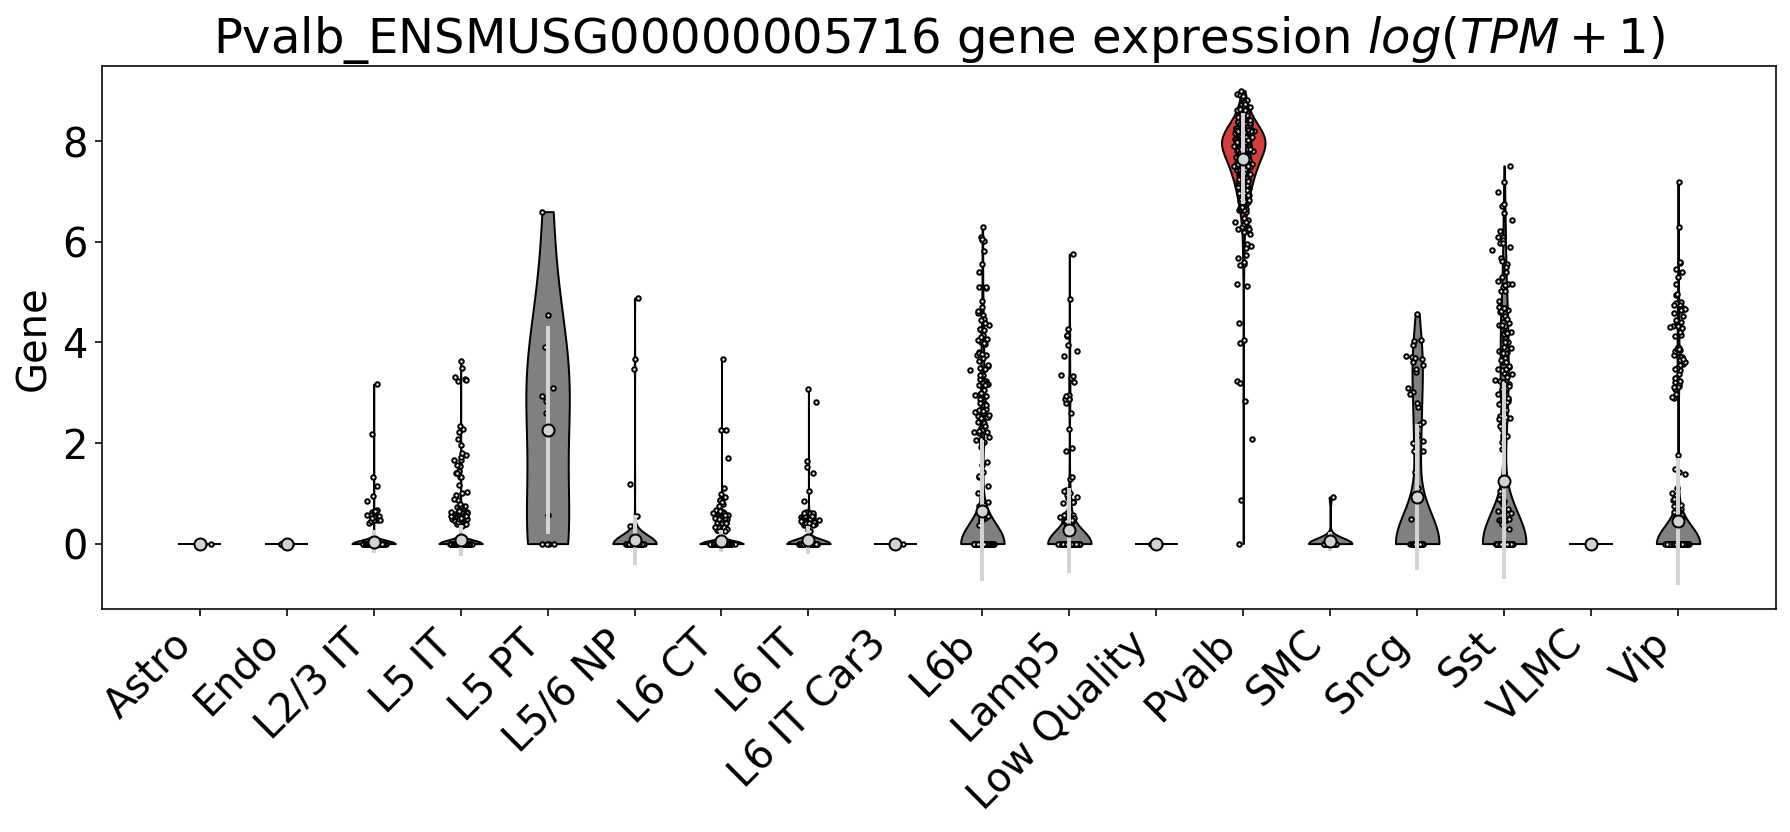

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.subclass_label.values)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]


#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax,selected=midx, xticks=lidx, xticklabels=labels)

ax.set(**{
    "ylabel": "Gene",
    "title": "{} gene expression $log(TPM + 1)$".format(specific_gene)
})

#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [32]:
identified_genes = markers_gene["name"].explode().astype(str)
identified_genes = identified_genes[identified_genes!="nan"]

In [33]:
print("{} genes identified.".format(identified_genes.nunique()))

9810 genes identified.


In [34]:
markers_gene.to_csv("../../tables/unordered/union_test_subclass_DE.csv")

In [35]:
gene[gene.obs.subclass_label=="L5 IT"].obs.cluster_label.value_counts()

L5 IT Rspo1      624
L5 IT Rspo2      256
L5 IT S100b_1    251
L5 IT Tcap_1     226
L5 IT Tcap_2     120
L5 IT S100b_2     82
L5 IT Pld5        12
Name: cluster_label, dtype: int64